In [43]:
import torch
import numpy as np
import os
import cma
from eval import play
from gan.config import SmallModelConfig
from gan.models.small_models import Generator
from play_rl.zelda_astar import play_astar
from gan.utils import tensor_to_level_str,check_playable
from gan.level_visualizer import LevelVisualizer
from play_rl.env import Env
from play_rl.wrappers import GridGame
from play_rl.policy import Policy
from PIL import Image

In [44]:
config = SmallModelConfig()
config.set_env()
config.cuda = False
if config.cuda:
    device = torch.device(
        "cuda" if torch.cuda.is_available else "cpu")
    print("device : cuda")
else:
    device = torch.device("cpu")
    print("device : cpu")
generator = Generator(
    out_dim=config.input_shape[0],
    shapes=config.model_shapes,
    z_shape=(config.latent_size,),
    filters=config.generator_filters,
    use_linear4z2features_g=False
).to(device)
env_def = Env(config.env_name,config.env_version)
level_visualizer = LevelVisualizer(env=env_def)

# model_path = os.path.join(
#     "/root/mnt/GVGAI-GAN/gan/checkpoints/_ours-152", "models_3800.tar")
# model_path = os.path.join(
#     "/root/mnt/GVGAI-GAN/gan/checkpoints/_boot_baseline-161", "models_3500.tar")
model_path = os.path.join(
    '/root/mnt/GVGAI-GAN/gan/checkpoints/_only5-121','models_1240.tar'
)

load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
x = torch.randn(config.latent_size).to(device)


device : cpu


Connecting to host 127.0.0.1 at port 53487 ...
Client connected to server [OK]
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=1034702, Sun Sep 11 12:27:43 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 6.800000000000000e+01 1.0e+00 4.70e-01  5e-01  5e-01 0:00.1
    2     28 1.000000000000000e+02 1.1e+00 4.51e-01  4e-01  5e-01 0:00.2
    3     42 6.800000000000000e+01 1.1e+00 4.34e-01  4e-01  4e-01 0:00.3
   49    686 6.700000000000000e+01 1.8e+00 4.04e-01  4e-01  4e-01 0:03.3
  100   1400 6.500000000000000e+01 2.2e+00 3.54e-01  3e-01  4e-01 0:07.3
  173   2422 6.500000000000000e+01 3.2e+00 2.91e-01  3e-01  3e-01 0:12.4
  200   2800 6.400000000000000e+01 3.5e+00 1.98e-01  2e-01  2e-01 0:14.5
  251   3514 6.300000000000000e+01 4.5e+00 1.93e-01  2e-01  2e-01 0:17.8
INIT:  [-1.30624342  2.17253709 -1.26194882  0.70168698  0.48670536 -0.68561083
 -1.16792929 -0.72163409  2.15598607 -0.26396698 -0.06198801 -0.6816451
 -0.41735104  1.5288

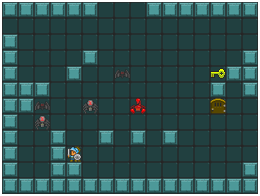

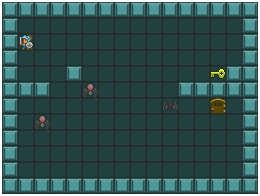

In [45]:
def eval(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return - wall - enemy


env = GridGame(config.env_name, 200, env_def.state_shape)
actor = Policy(env.observation_space.shape, env.action_space,base_kwargs={"recurrent": True})
actor.load_state_dict(torch.load('/root/mnt/GVGAI-GAN/play_rl/checkpoints/ppo/zelda_20220825102126.pt'))

def fitness(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1, 1, 1)
    level = generator(latent)
    level_str = tensor_to_level_str('zelda', level)
    playable = check_playable(level_str[0])
    if not playable:
        return 100
    # reward,step,_ = play(level_str[0],env=env,actor=actor)
    # reward, step, _ = play_astar(level_str[0], env=env)

    # return -(reward*100+step)
    ev = eval(level_str)
    return -ev

def show(x):
    p_level = torch.nn.Softmax2d()(generator(x))
    level_strs = tensor_to_level_str(
        config.env_name, p_level)
    p_level_img = np.array(level_visualizer.draw_level(level_strs[0]))
    image = Image.fromarray(p_level_img)
    image.show()

es = cma.CMAEvolutionStrategy(x.tolist(), 0.5)
# es.optimize(fitness,iterations=30,min_iterations=30)
es.optimize(fitness)
best = np.array(es.best.get()[0])
print("INIT: ", np.array(x.tolist()))
print("BEST: ", best)
print("Fitness: ", fitness(best))
show(x)
show(torch.FloatTensor(best))

# sum = 0
# N = 10
# for i in range(N):
#     x = torch.randn(config.latent_size).to(device)
#     es = cma.CMAEvolutionStrategy(x.tolist(), 0.5)
#     es.optimize(fitness)
#     best = np.array(es.best.get()[0])
#     sum += fitness(best)

# print("mean:",best/N)


In [46]:
print("mean:", sum/N)


mean: 58.3
